In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
print("✅ Библиотеки загружены!")

✅ Библиотеки загружены!


# 🎯 ДЗ 3: ОБНАРУЖЕНИЕ ЛИНИЙ И КОНТУРОВ

## 1. 📷 ЗАГРУЗКА ИЗОБРАЖЕНИЯ

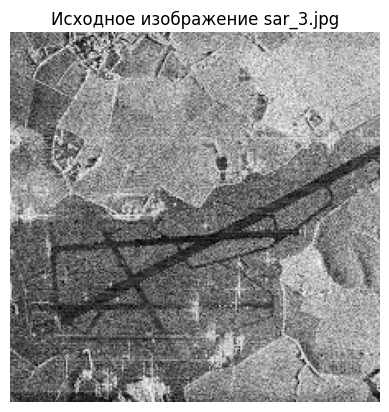

In [2]:
image = cv2.imread('sar_3.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
plt.imshow(image_gray, cmap="gray")
plt.title('Исходное изображение sar_3.jpg')
plt.axis('off')
plt.show()

## 2. 🔲 МЕТОДЫ БИНАРИЗАЦИИ

🔹 ТОЧЕЧНАЯ БИНАРИЗАЦИЯ
   Порог: 50


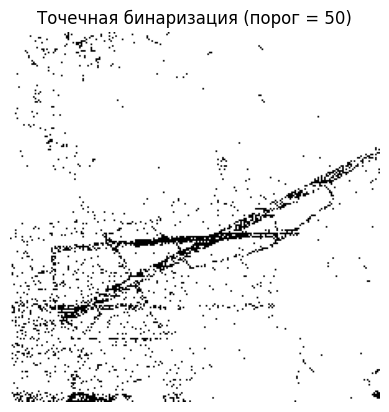

In [3]:
# Точечная бинаризация
import copy

bin_img = copy.deepcopy(image_gray)
T  = 50
bin_img[image_gray < T] = 0
bin_img[image_gray >= T] = 255

print("🔹 ТОЧЕЧНАЯ БИНАРИЗАЦИЯ")
print(f"   Порог: {T}")

plt.imshow(bin_img, cmap="gray")
plt.title('Точечная бинаризация (порог = 50)')
plt.axis('off')
plt.show()

🔹 БИНАРИЗАЦИЯ ОТСУ
   Автоматический порог: 129.0


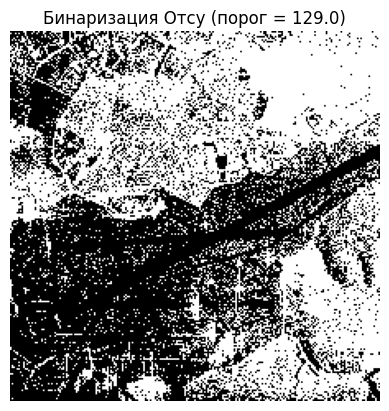

In [4]:
# Бинаризация Отсу
_, th2 = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

print("🔹 БИНАРИЗАЦИЯ ОТСУ")
print(f"   Автоматический порог: {_}")

plt.imshow(th2, cmap="gray")
plt.title(f'Бинаризация Отсу (порог = {_:.1f})')
plt.axis('off')
plt.show()

🔹 АДАПТИВНАЯ БИНАРИЗАЦИЯ
   Параметры: окно 71x71, константа = 21


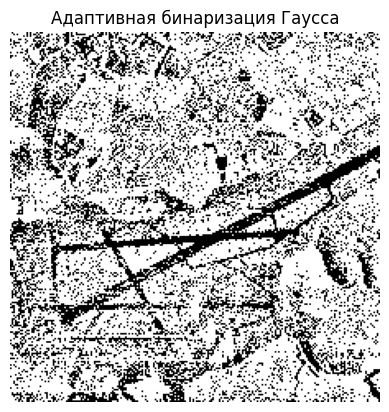

In [5]:
# Адаптивная бинаризация
th3 = cv2.adaptiveThreshold(image_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY, 71, 21)

print("🔹 АДАПТИВНАЯ БИНАРИЗАЦИЯ")
print("   Параметры: окно 71x71, константа = 21")

plt.imshow(th3, cmap="gray")
plt.title('Адаптивная бинаризация Гаусса')
plt.axis('off')
plt.show()

## 3. 🎯 ОПЕРАТОРЫ ОБНАРУЖЕНИЯ ГРАНИЦ

🔹 ОПЕРАТОР СОБЕЛЯ


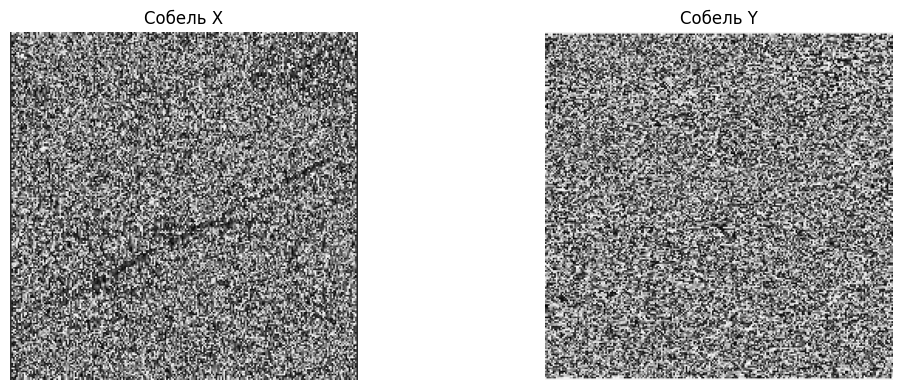

In [6]:
# Оператор Собеля
scale = 1
delta = 0
ddepth = cv2.CV_16S

print("🔹 ОПЕРАТОР СОБЕЛЯ")

grad_x = cv2.Sobel(image_gray, ddepth, 1, 0, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)
grad_y = cv2.Sobel(image_gray, ddepth, 0, 1, ksize=3, scale=scale, delta=delta, borderType=cv2.BORDER_DEFAULT)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.imshow((grad_x - grad_x.min())*255, cmap="gray")
plt.title('Собель X')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow((grad_y - grad_y.min())*255, cmap="gray")
plt.title('Собель Y')
plt.axis('off')

plt.tight_layout()
plt.show()

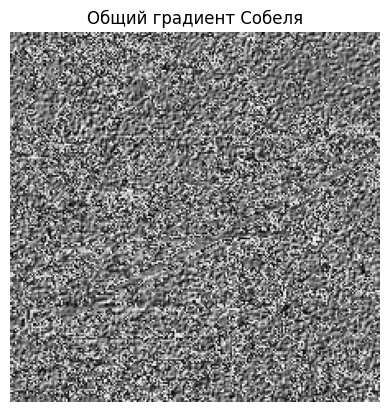

In [7]:
# Общий градиент Собеля
grad = cv2.addWeighted(grad_x, 0.5, grad_y, 0.5, 0.0) # mean value between

plt.imshow((grad - grad.min())*255, cmap="gray")
plt.title('Общий градиент Собеля')
plt.axis('off')
plt.show()

🔹 ДЕТЕКТОР КАННИ
   Параметры: нижний порог = 100, верхний порог = 200


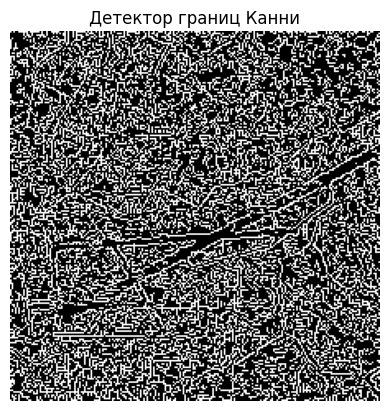

In [8]:
# Canny
edges = cv2.Canny(image_gray, 100, 200)

print("🔹 ДЕТЕКТОР КАННИ")
print("   Параметры: нижний порог = 100, верхний порог = 200")

plt.imshow(edges, cmap="gray")
plt.title('Детектор границ Канни')
plt.axis('off')
plt.show()

## 4. 📐 ПРЕОБРАЗОВАНИЕ ХАФА - ПОИСК САМОЙ ДЛИННОЙ ЛИНИИ

🔹 ПОДГОТОВКА К ПРЕОБРАЗОВАНИЮ ХАФА


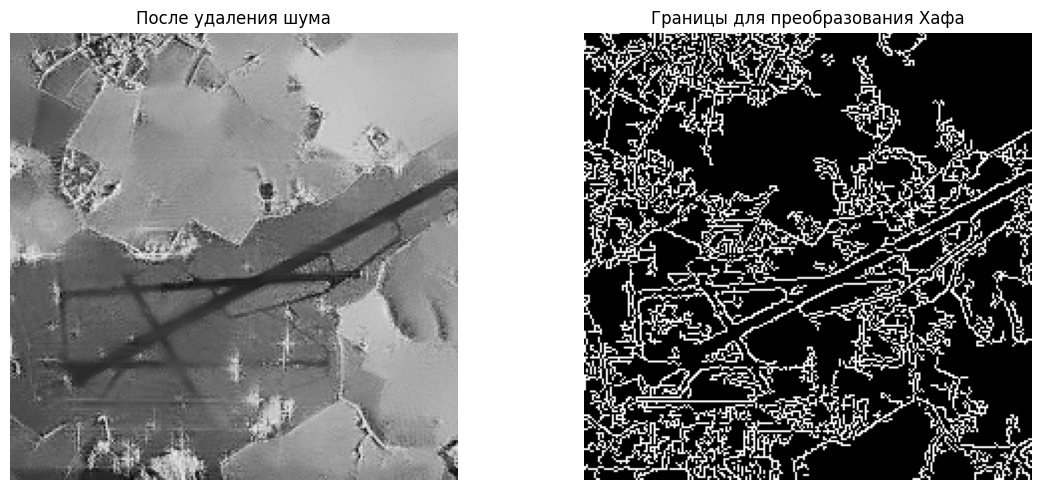

In [9]:
# Преобразование Хафа
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
image_gray_hough = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

print("🔹 ПОДГОТОВКА К ПРЕОБРАЗОВАНИЮ ХАФА")

image_gauss_fastNl = cv2.fastNlMeansDenoising(image_gray_hough, h=20)
canny = cv2.Canny(image_gauss_fastNl, 0, 250, apertureSize=3)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_gauss_fastNl, cmap='gray')
plt.title('После удаления шума')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(canny, cmap='gray')
plt.title('Границы для преобразования Хафа')
plt.axis('off')

plt.tight_layout()
plt.show()

✅ Найдено линий: 3
🎯 Самая длинная линия: длина = 1998.8 пикселей


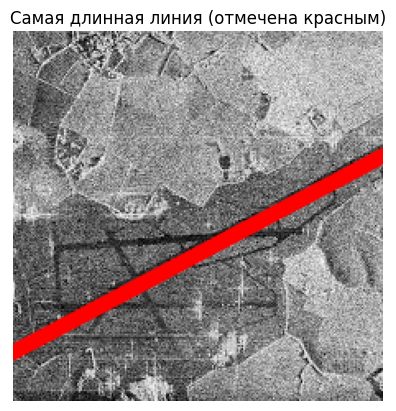

In [10]:
# Поиск самой длинной линии
lines = cv2.HoughLines(canny, 1, np.pi / 180, 110)

max_length = 0
longest_line = None
image_copy = image_rgb.copy()

if lines is not None:
    print(f"✅ Найдено линий: {len(lines)}")
    
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        length = np.sqrt((pt1[0] - pt2[0])**2 + (pt1[1] - pt2[1])**2)
        
        if length > max_length:
            max_length = length
            longest_line = (pt1, pt2)
    
    if longest_line:
        cv2.line(image_copy, longest_line[0], longest_line[1], (255, 0, 0), 7, cv2.LINE_AA)
        print(f"🎯 Самая длинная линия: длина = {max_length:.1f} пикселей")

plt.imshow(image_copy)
plt.title('Самая длинная линия (отмечена красным)')
plt.axis('off')
plt.show()

## 5. 🛣️ ВЫДЕЛЕНИЕ КОНТУРОВ ДОРОЖНОЙ ПОЛОСЫ

🔹 ВЫДЕЛЕНИЕ КОНТУРОВ ДОРОЖНОЙ ПОЛОСЫ
   Порог бинаризации: 80
✅ Найдено контуров: 113
✅ Отфильтровано контуров (площадь > 350): 2


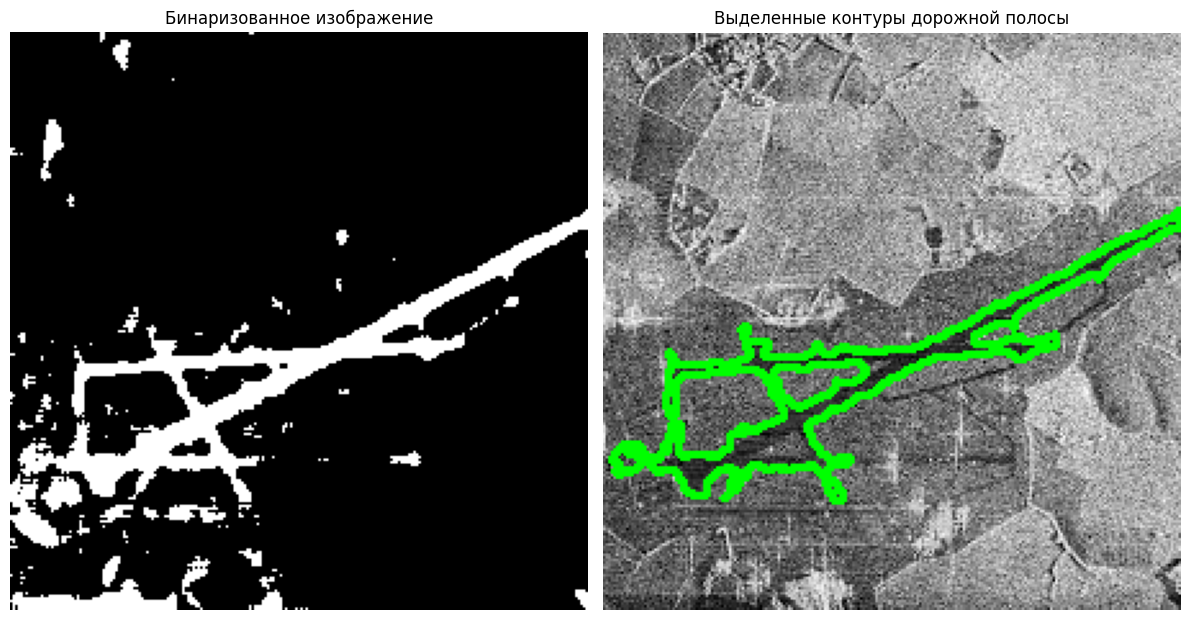

In [11]:
# Выделение контуров дорожной полосы
filtered_image = cv2.medianBlur(image_gray, 5)
thresh = 80
ret, thresh_img = cv2.threshold(filtered_image, thresh, 255, cv2.THRESH_BINARY_INV)

print("🔹 ВЫДЕЛЕНИЕ КОНТУРОВ ДОРОЖНОЙ ПОЛОСЫ")
print(f"   Порог бинаризации: {thresh}")

contours, hierarchy = cv2.findContours(thresh_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = image_rgb.copy()

contours_itog = []
min_area = 350

for contour in contours:
    if len(contour) > 1:
        area = cv2.contourArea(contour)
        if area > min_area:
            contours_itog.append(contour)

print(f"✅ Найдено контуров: {len(contours)}")
print(f"✅ Отфильтровано контуров (площадь > {min_area}): {len(contours_itog)}")

cv2.drawContours(image_with_contours, contours_itog, -1, (0, 255, 0), 2)

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.imshow(thresh_img, cmap='gray')
plt.title('Бинаризованное изображение')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_with_contours)
plt.title('Выделенные контуры дорожной полосы')
plt.axis('off')

plt.tight_layout()
plt.show()

## 6. 🎨 ИТОГОВОЕ ИЗОБРАЖЕНИЕ

🎯 ИТОГОВЫЙ РЕЗУЛЬТАТ


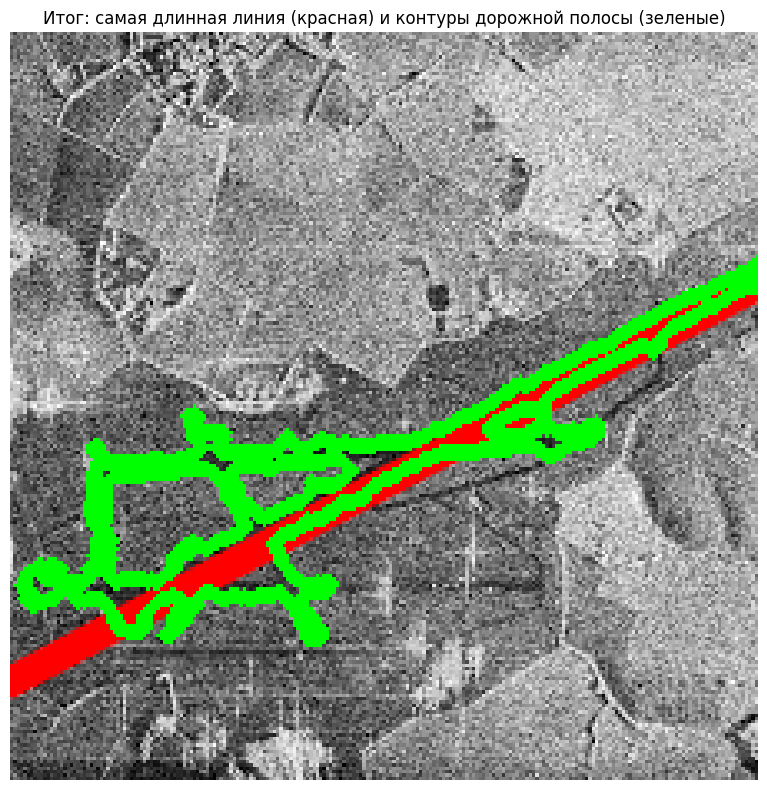

In [12]:
# Итоговое изображение с линией и контурами
final_image = image_rgb.copy()

# Рисуем самую длинную линию
if longest_line:
    cv2.line(final_image, longest_line[0], longest_line[1], (255, 0, 0), 7, cv2.LINE_AA)

# Рисуем контуры
cv2.drawContours(final_image, contours_itog, -1, (0, 255, 0), 3)

print("🎯 ИТОГОВЫЙ РЕЗУЛЬТАТ")

plt.figure(figsize=(10, 8))
plt.imshow(final_image)
plt.title('Итог: самая длинная линия (красная) и контуры дорожной полосы (зеленые)')
plt.axis('off')
plt.tight_layout()
plt.show()